<a href="https://colab.research.google.com/github/Munna-Prasad-Gupta/ML/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install datasets
import numpy as np
import pandas as pd
import string
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
from datasets import load_dataset
df = load_dataset("Aarif1430/english-to-hindi")
da = pd.DataFrame(df['train'])

# Data Preprocessing
da.rename(columns={'english_sentence': 'english', 'hindi_sentence': 'hindi'}, inplace=True)
da['english'] = da['english'].str.replace('[{}]'.format(string.punctuation), '').str.lower()
da['hindi'] = da['hindi'].str.replace('[{}]'.format(string.punctuation), '').str.lower()

# Remove empty rows
eng_empty_indices = da[da['english'].str.strip().astype(bool) == False].index
hin_empty_indices = da[da['hindi'].str.strip().astype(bool) == False].index
remove_indices = list(set(eng_empty_indices) | set(hin_empty_indices))
da.drop(remove_indices, inplace=True)
da.reset_index(drop=True, inplace=True)

# Tokenization
tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(da['english'])
sequences_eng = tokenizer_eng.texts_to_sequences(da['english'])

tokenizer_hin = Tokenizer()
tokenizer_hin.fit_on_texts(da['hindi'])
sequences_hin = tokenizer_hin.texts_to_sequences(da['hindi'])

# Pad sequences
max_length = 100
sequences_eng = pad_sequences(sequences_eng, maxlen=max_length, padding='post')
sequences_hin = pad_sequences(sequences_hin, maxlen=max_length, padding='post')

# Vocabulary sizes
vocab_size_eng = len(tokenizer_eng.word_index) + 1
vocab_size_hin = len(tokenizer_hin.word_index) + 1

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(sequences_eng[:50000], sequences_hin[:50000], test_size=0.2, random_state=42)

# Build and fine-tune the LSTM model
model = Sequential()

# Embedding layer with increased dimensionality
model.add(Embedding(input_dim=vocab_size_eng, output_dim=256, input_length=max_length, mask_zero=True))

# First LSTM layer with Dropout for regularization
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.3))  # Dropout layer to prevent overfitting

# Batch Normalization after the first LSTM layer
model.add(BatchNormalization())

# Second LSTM layer with Dropout
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.3))

# Another LSTM layer for deeper representation
model.add(LSTM(units=512))
model.add(Dropout(0.3))

# Repeat vector for the decoder
model.add(RepeatVector(max_length))

# Decoder LSTM layer
model.add(LSTM(units=1024, return_sequences=True))

# Output layer with softmax activation
model.add(Dense(units=vocab_size_hin, activation='softmax'))

# Compile the model
rms = RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('fine_tuned_lstm_model.h5')

# Save the training history
with open('fine_tuned_lstm_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Optionally, plot accuracy as well
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Define a function to translate a sentence
def translate_sentence(input_sentence, model, tokenizer_eng, tokenizer_hin, max_length):
    """
    Translates an English sentence to Hindi using the trained model.

    Parameters:
        input_sentence (str): The English sentence to translate.
        model (Sequential): The trained Seq2Seq model.
        tokenizer_eng (Tokenizer): The tokenizer for English.
        tokenizer_hin (Tokenizer): The tokenizer for Hindi.
        max_length (int): The maximum length of sequences.

    Returns:
        str: The translated Hindi sentence.
    """
    # Preprocess the input sentence
    input_sentence = input_sentence.lower().translate(str.maketrans('', '', string.punctuation))
    input_sequence = tokenizer_eng.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Predict the output sequence
    prediction = model.predict(input_sequence, verbose=0)
    predicted_sequence = np.argmax(prediction, axis=-1)

    # Convert the sequence of integers to words
    hindi_words = []
    for idx in predicted_sequence[0]:
        if idx == 0:  # Padding token
            continue
        hindi_word = tokenizer_hin.index_word.get(idx, '')
        if hindi_word == '':  # Stop if an unknown token or end token is encountered
            break
        hindi_words.append(hindi_word)

    return ' '.join(hindi_words)

# Example usage:
english_sentence = "Hello, how are you?"
hindi_translation = translate_sentence(english_sentence, model, tokenizer_eng, tokenizer_hin, max_length)
print("Translated sentence:", hindi_translation)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


README.md:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

(…)-00000-of-00001-71c2cec7402cd444.parquet:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127705 [00:00<?, ? examples/s]

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_1/dense_1/MatMul/MatMul_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-1-9b341bf06ff4>", line 97, in <cell line: 97>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

OOM when allocating tensor with shape[64,1024,77198] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/dense_1/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_5055]

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - accuracy: 0.6733 - loss: 2.9397 - val_accuracy: 0.6900 - val_loss: 2.4182 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6850 - loss: 2.4511 - val_accuracy: 0.6901 - val_loss: 2.3839 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6874 - loss: 2.4058 - val_accuracy: 0.6903 - val_loss: 2.3688 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6834 - loss: 2.4160 - val_accuracy: 0.6906 - val_loss: 2.3596 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6863 - loss: 2.3780 - val_accuracy: 0.6851 - val_loss: 2.3892 - learning_rate: 0.0010
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6882 - loss: 2.3466 - val_accuracy: 0.6890 - val_loss: 2.3410 - learning_rate: 0.0010
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accura

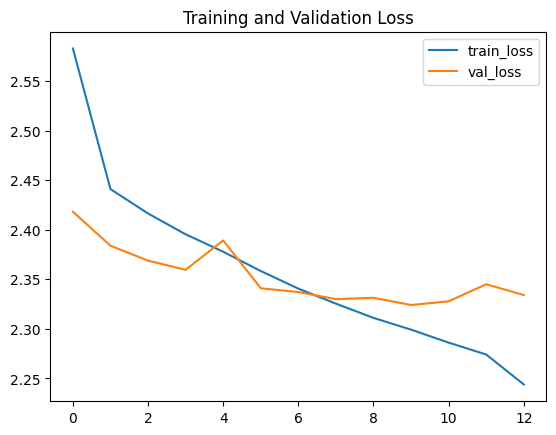

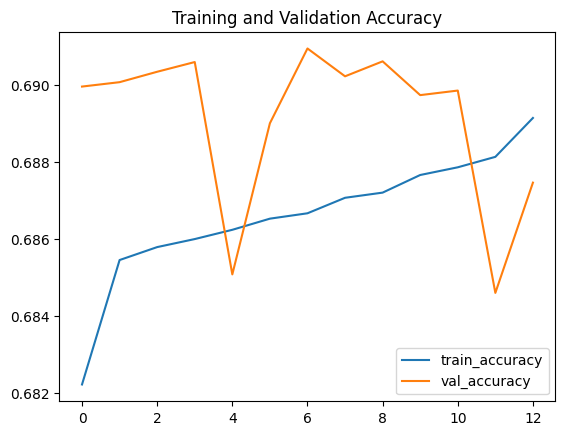

Translated sentence: और हम


In [3]:
import numpy as np
import pandas as pd
import string
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
from datasets import load_dataset
df = load_dataset("Aarif1430/english-to-hindi")
da = pd.DataFrame(df['train'])

# Data Preprocessing
da.rename(columns={'english_sentence': 'english', 'hindi_sentence': 'hindi'}, inplace=True)
da['english'] = da['english'].str.replace('[{}]'.format(string.punctuation), '').str.lower()
da['hindi'] = da['hindi'].str.replace('[{}]'.format(string.punctuation), '').str.lower()

# Remove empty rows
da.dropna(subset=['english', 'hindi'], inplace=True)
da = da[da['english'].str.strip() != '']
da = da[da['hindi'].str.strip() != '']
da.reset_index(drop=True, inplace=True)

# Tokenization with limited vocabulary
max_vocab_size = 20000  # Limit vocabulary size for both languages
tokenizer_eng = Tokenizer(num_words=max_vocab_size, filters='')
tokenizer_eng.fit_on_texts(da['english'])
sequences_eng = tokenizer_eng.texts_to_sequences(da['english'])

tokenizer_hin = Tokenizer(num_words=max_vocab_size, filters='')
tokenizer_hin.fit_on_texts(da['hindi'])
sequences_hin = tokenizer_hin.texts_to_sequences(da['hindi'])

# Pad sequences
max_length = 50  # Reduced max sequence length
sequences_eng = pad_sequences(sequences_eng, maxlen=max_length, padding='post')
sequences_hin = pad_sequences(sequences_hin, maxlen=max_length, padding='post')

# Vocabulary sizes
vocab_size_eng = min(max_vocab_size, len(tokenizer_eng.word_index) + 1)
vocab_size_hin = min(max_vocab_size, len(tokenizer_hin.word_index) + 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(sequences_eng[:50000], sequences_hin[:50000], test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size_eng, output_dim=128, input_length=max_length, mask_zero=True))

# LSTM layers with cuDNN disabled
model.add(LSTM(units=256, return_sequences=True, use_cudnn=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(units=256, use_cudnn=False))
model.add(Dropout(0.2))

# Repeat vector for the decoder
model.add(RepeatVector(max_length))

# Decoder LSTM layer
model.add(LSTM(units=256, return_sequences=True, use_cudnn=False))
model.add(Dropout(0.2))

# Output layer with reduced vocabulary size
model.add(Dense(units=vocab_size_hin, activation='softmax'))

# Compile the model with gradient clipping
rms = RMSprop(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('optimized_lstm_model.h5')

# Save the training history
with open('optimized_lstm_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Optionally, plot accuracy as well
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Define a function to translate a sentence
def translate_sentence(input_sentence, model, tokenizer_eng, tokenizer_hin, max_length):
    """
    Translates an English sentence to Hindi using the trained model.

    Parameters:
        input_sentence (str): The English sentence to translate.
        model (Sequential): The trained Seq2Seq model.
        tokenizer_eng (Tokenizer): The tokenizer for English.
        tokenizer_hin (Tokenizer): The tokenizer for Hindi.
        max_length (int): The maximum length of sequences.

    Returns:
        str: The translated Hindi sentence.
    """
    # Preprocess the input sentence
    input_sentence = input_sentence.lower().translate(str.maketrans('', '', string.punctuation))
    input_sequence = tokenizer_eng.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Predict the output sequence
    prediction = model.predict(input_sequence, verbose=0)
    predicted_sequence = np.argmax(prediction, axis=-1)

    # Convert the sequence of integers to words
    hindi_words = [tokenizer_hin.index_word.get(idx, '') for idx in predicted_sequence[0] if idx != 0]
    return ' '.join(hindi_words)

# Example usage:
english_sentence = "Hello, how are you?"
hindi_translation = translate_sentence(english_sentence, model, tokenizer_eng, tokenizer_hin, max_length)
print("Translated sentence:", hindi_translation)
